In [13]:
# tensorflow 2.15.0 기준 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [15]:
print(tf.__version__)

2.15.0


In [16]:
file_path = '/Users/leeshinhee/Documents/newdeal/project/code_models/dataset/dataset2_70/5_dog_breed_image_dataset/'

test_dir = os.path.join(file_path, 'test')

BATCH_SIZE =16
IMG_SIZE = (224, 224)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           label_mode = 'int')
class_names = test_dataset.class_names


Found 50 files belonging to 5 classes.


In [17]:
# augmentation 데이터 증강 (나중에 flip rotation 외의 증강 있는지 찾아보기)

# 레이어가 플랫화 되지 않은것 같아서 class로 만들어서 get_config 넣음
class CustomDataAugmentation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomDataAugmentation, self).__init__(**kwargs)
        self.flip = tf.keras.layers.RandomFlip('horizontal')
        self.rotate = tf.keras.layers.RandomRotation(0.2)

    def call(self, inputs, training = None):
        if training:
            inputs = self.flip(inputs)
            inputs = self.rotate(inputs)
        return inputs

    def get_config(self):
        config = super(CustomDataAugmentation, self).get_config()
        return config

tf.keras.utils.register_keras_serializable()(CustomDataAugmentation)
data_augmentation = CustomDataAugmentation()

# #agumentaion class말고 그냥 넣기
# data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
#                                          tf.keras.layers.RandomRotation(0.2),])

In [18]:
# include_top=False -> 원 모델의 맨 위 분류층을 포함하지 않도록 함 -> 학습하려는 데이터셋의 특징 추출에 유리

IMG_SHAPE = IMG_SIZE + (3,)

# 이렇게 가져오는거를 인스턴스화 한다고 표현
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
# precess input 레이어를 직렬화 하면서 해당 레이어에 output shape 전달해주기 위해 함수화
# tf 내장 모델의 경우 각 고유의 precess_input을 가지고 있음
preprocess_input = tf.keras.applications.vgg16.preprocess_input

@tf.keras.utils.register_keras_serializable()
def preprocess_input_lambda(x):
    x = preprocess_input(x)
    return (x,)

In [20]:
# model load
model_path = "/Users/leeshinhee/Documents/newdeal/project/CloudAiProject_team1_preprocessing/models/model_tf2150_epoch100_240610_1702.keras"
model_loaded = tf.keras.models.load_model(model_path, custom_objects={
    'preprocess_input_lambda': preprocess_input_lambda,
    'CustomDataAugmentation': CustomDataAugmentation,
}, safe_mode = False, compile=False)

# 옵티마이저 문제가 발생하여 모델에서 불러오지 않고 재 설정
model_loaded.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model_loaded.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 custom_data_augmentation (  (None, 224, 224, 3)       0         
 CustomDataAugmentation)                                         
                                                                 
 lambda (Lambda)             ((None, 224, 224, 3),     0         
                             )                                   
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [22]:
# test

loss, accuracy = model_loaded.evaluate(test_dataset)
print("test loss:", loss)
print('Test accuracy :', accuracy)

4/4 [==============================] - 5s 1s/step - loss: 0.0073 - accuracy: 1.0000
test loss: 0.007344720885157585
Test accuracy : 1.0


Predictions per class:
 [[0.1488476  0.1488476  0.4046096  0.1488476  0.14884762]
 [0.14884791 0.40460917 0.14884764 0.14884764 0.14884764]
 [0.1488476  0.1488476  0.4046097  0.1488476  0.1488476 ]
 [0.14884876 0.40460774 0.14884782 0.14884782 0.14884782]
 [0.1488476  0.1488476  0.1488476  0.4046097  0.1488476 ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.1488476  0.1488476  0.4046097  0.1488476  0.1488476 ]
 [0.1489177  0.1489177  0.4040543  0.1491913  0.148919  ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.1488476  0.1488476  0.1488476  0.4046097  0.1488476 ]
 [0.1488477  0.40460873 0.1488477  0.1488477  0.14884815]
 [0.14884774 0.14884774 0.40460855 0.14884827 0.14884777]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.14884767 0.14884767 0.148848   0.14884767 0.404609  ]
 [0.14884865 0.14884865 0.14885285 0.14884865 0.4046012 ]]
Predictions:
 [2 1 2 1 3 0 0 2 2 0 3 1 2 0 4 4]

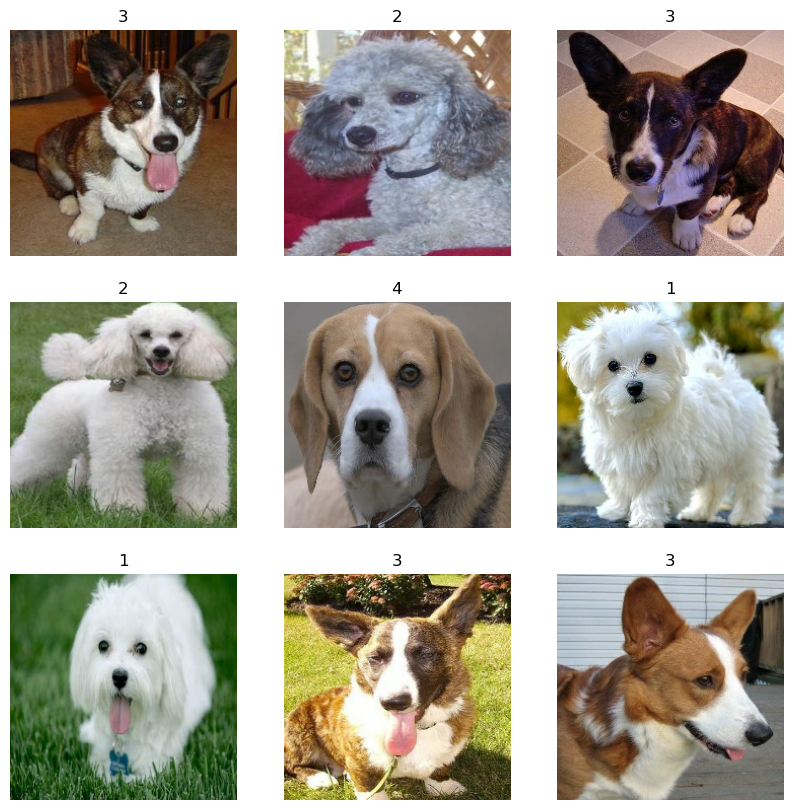

In [23]:
# test image 전달
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_loaded.predict_on_batch(image_batch)

# softmax 함수로 return하도록 함
predictions_classes = tf.nn.softmax(predictions)
predictions = tf.argmax(predictions_classes, axis = 1)

print('Predictions per class:\n', predictions_classes.numpy())
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions per class:
 [[0.1488476  0.4046097  0.1488476  0.1488476  0.1488476 ]
 [0.15723194 0.15723196 0.21340148 0.15723355 0.3149011 ]
 [0.1488476  0.1488476  0.4046097  0.1488476  0.1488476 ]
 [0.14884782 0.4046078  0.14884782 0.14884782 0.14884874]
 [0.14884758 0.14884758 0.14884758 0.14884758 0.40460968]
 [0.14884758 0.14884758 0.14884758 0.14884758 0.40460968]
 [0.148855   0.148855   0.148884   0.404551   0.148855  ]
 [0.1488476  0.1488476  0.4046097  0.1488476  0.1488476 ]
 [0.1488476  0.1488476  0.1488476  0.4046097  0.1488476 ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.1488476  0.1488476  0.1488476  0.4046097  0.1488476 ]
 [0.4046097  0.1488476  0.1488476  0.1488476  0.1488476 ]
 [0.1488477  0.40460873 0.1488477  0.1488477  0.14884815]
 [0.1488476  0.1488476  0.1488476  0.4046097  0.1488476 ]
 [0.1488476  0.1488476  0.4046097  0.1488476  0.1488476 ]]
Predictions:
 [1 4 2 1 4 4 3 2 3 0 0 3 0 1 3 2]

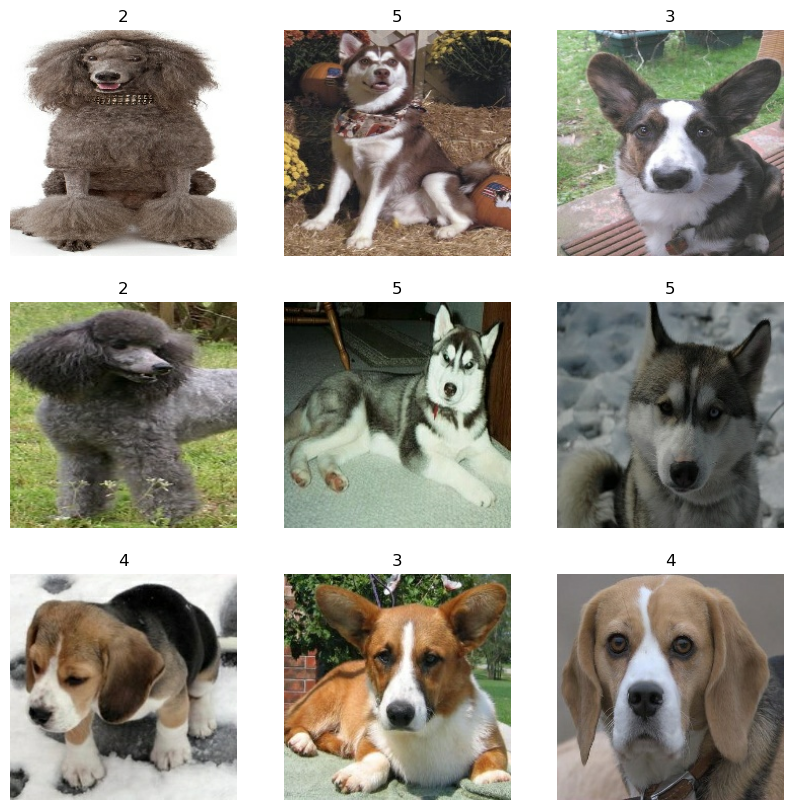

In [24]:
def get_test_file(file_path):
  test_file = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           label_mode = 'int')
  return test_file

# test image 전달
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_loaded.predict_on_batch(image_batch)

# softmax 함수로 return하도록 함
predictions_classes = tf.nn.softmax(predictions)
predictions = tf.argmax(predictions_classes, axis = 1)

print('Predictions per class:\n', predictions_classes.numpy())
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")